In [1]:
import numpy as np
import os,sys


sys.path.append('../..')
sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects_new/TEST_AAS/TEST/AAS-18-290_6DOF_manuscript/Run/Run_4km_terminal


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

6dof dynamics model
Quaternion_attitude
Thruster Config Shape:  (4, 6) 4
Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Reward_terminal
queue fixed
Flat Constraint
Attitude Constraint


<IPython.core.display.Javascript object>


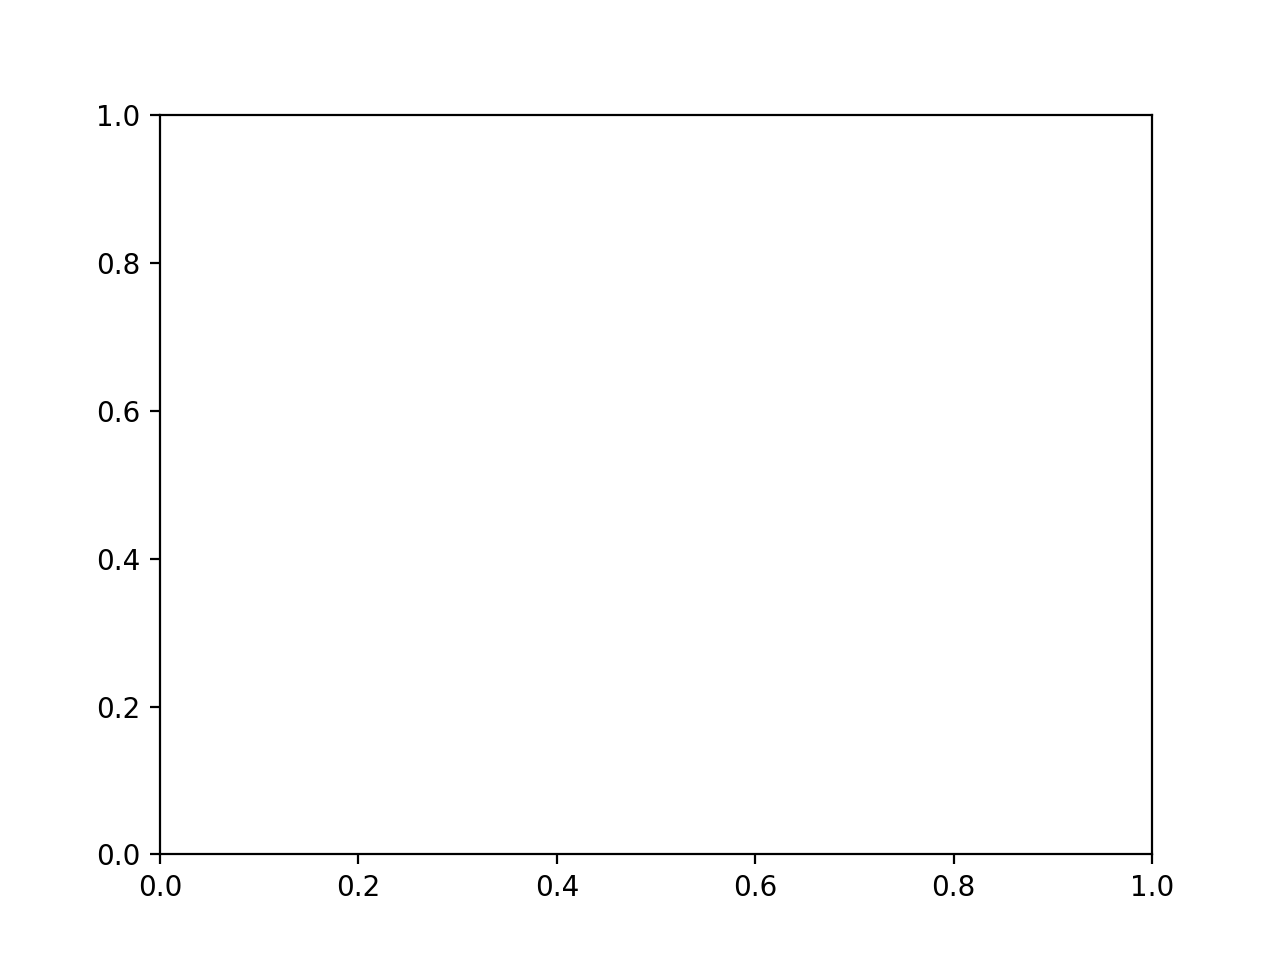

<IPython.core.display.Javascript object>


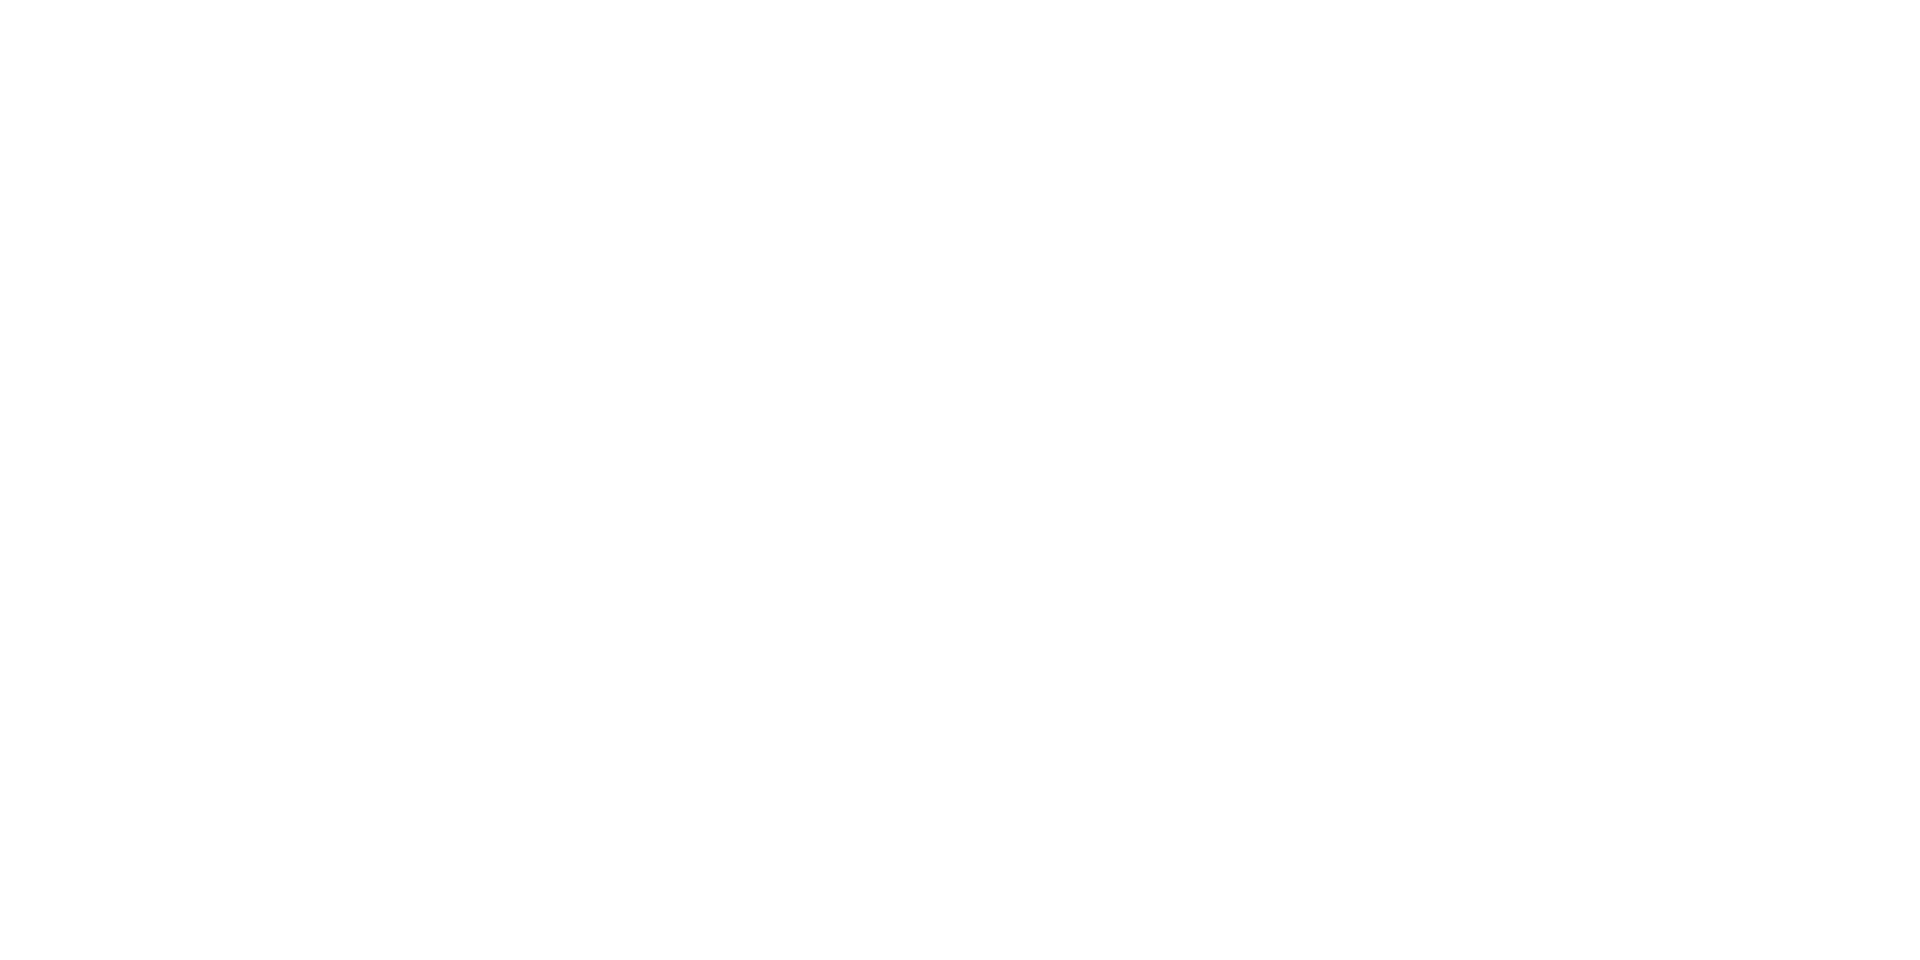

<IPython.core.display.Javascript object>


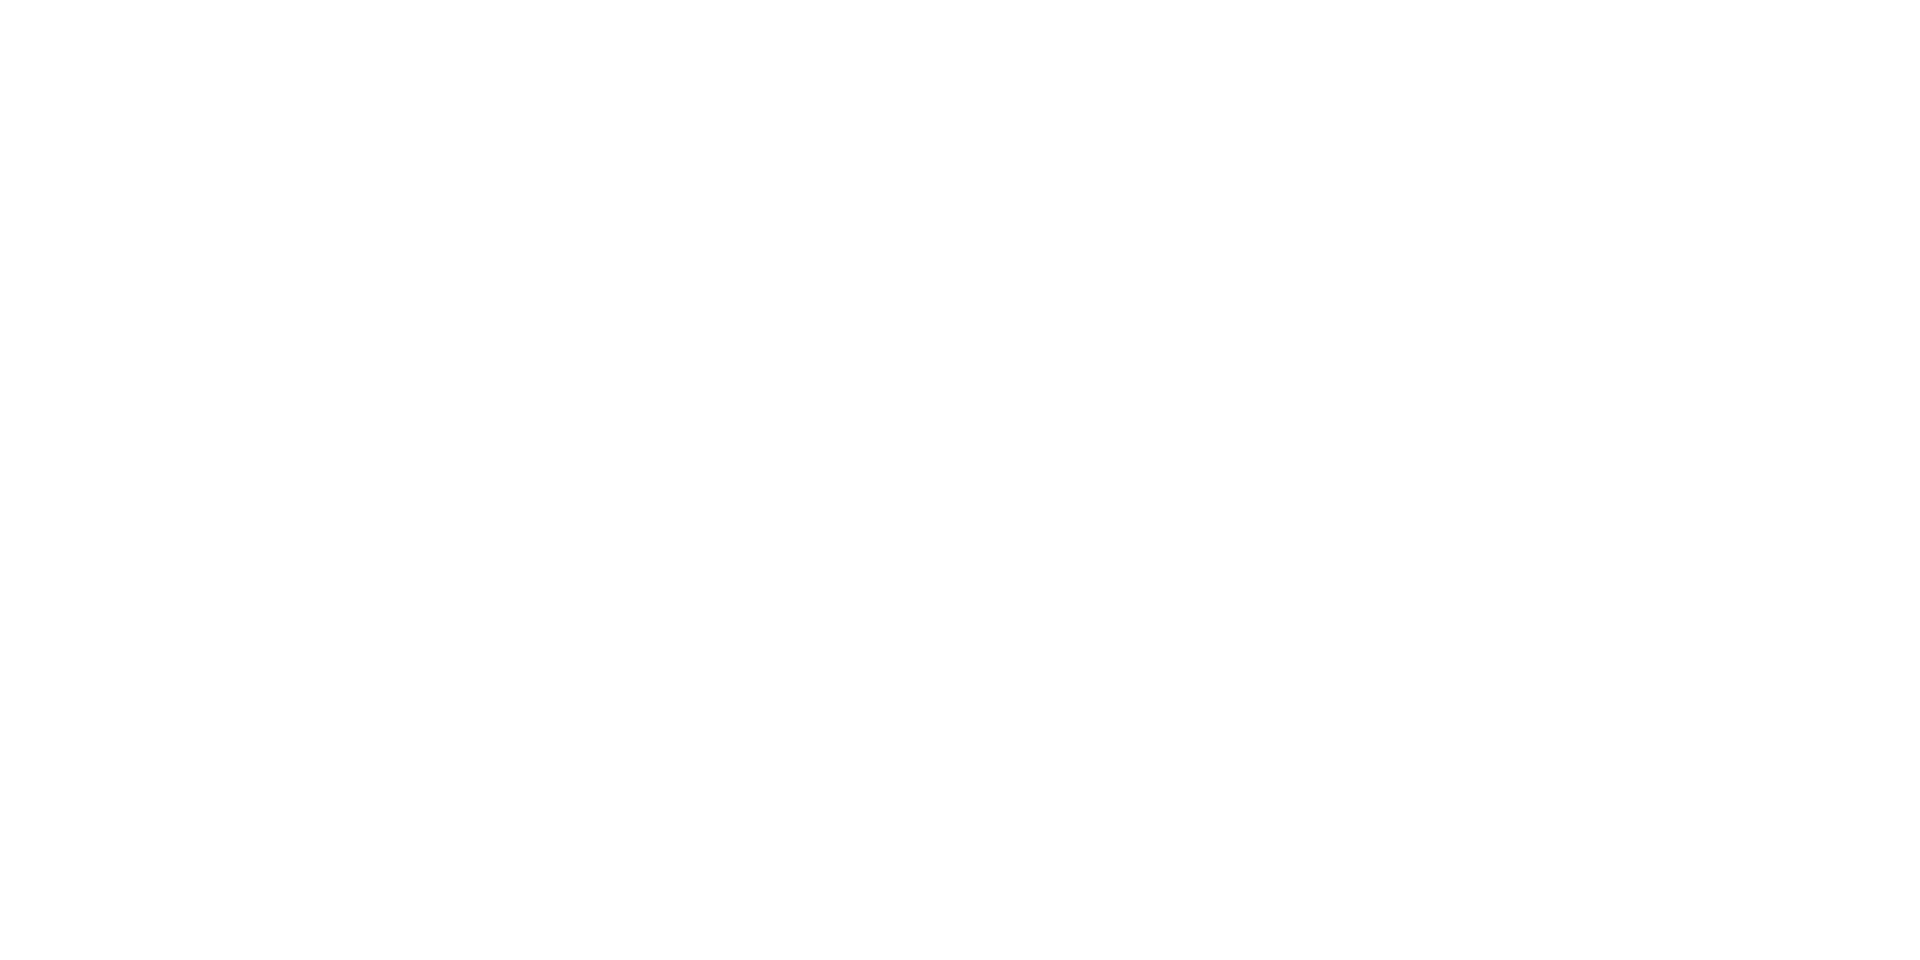

<IPython.core.display.Javascript object>


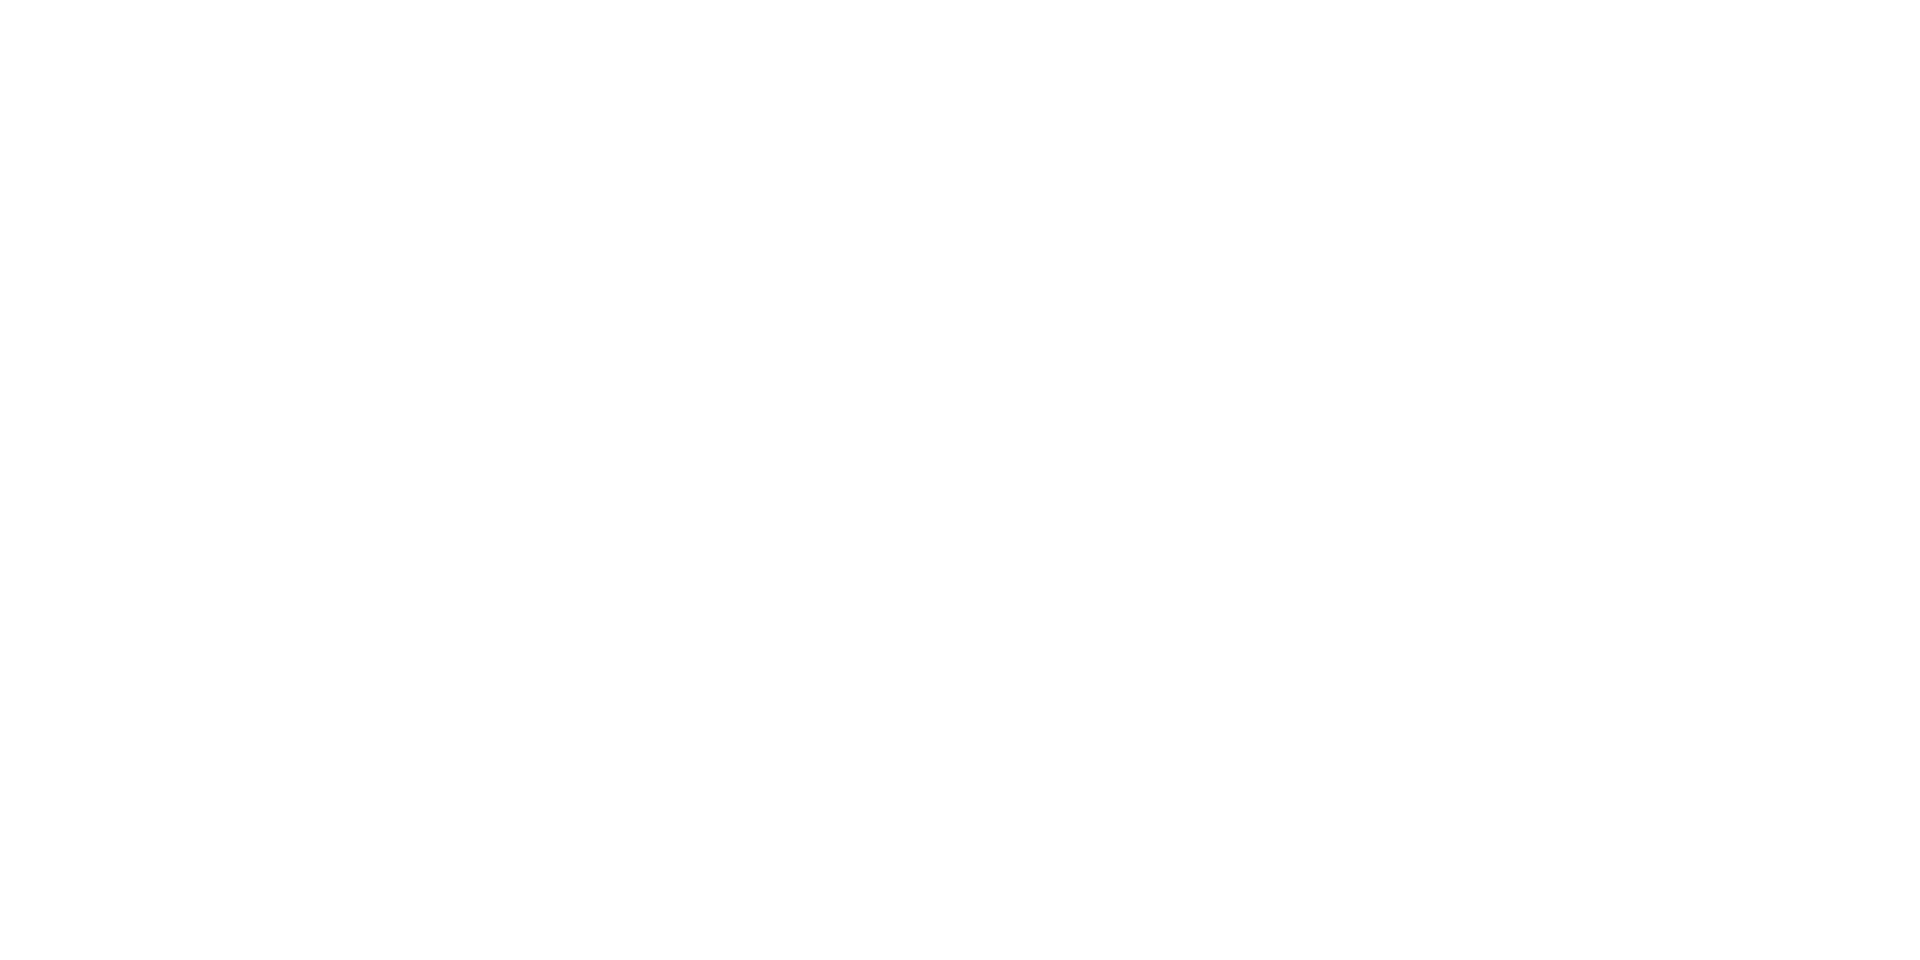

<IPython.core.display.Javascript object>


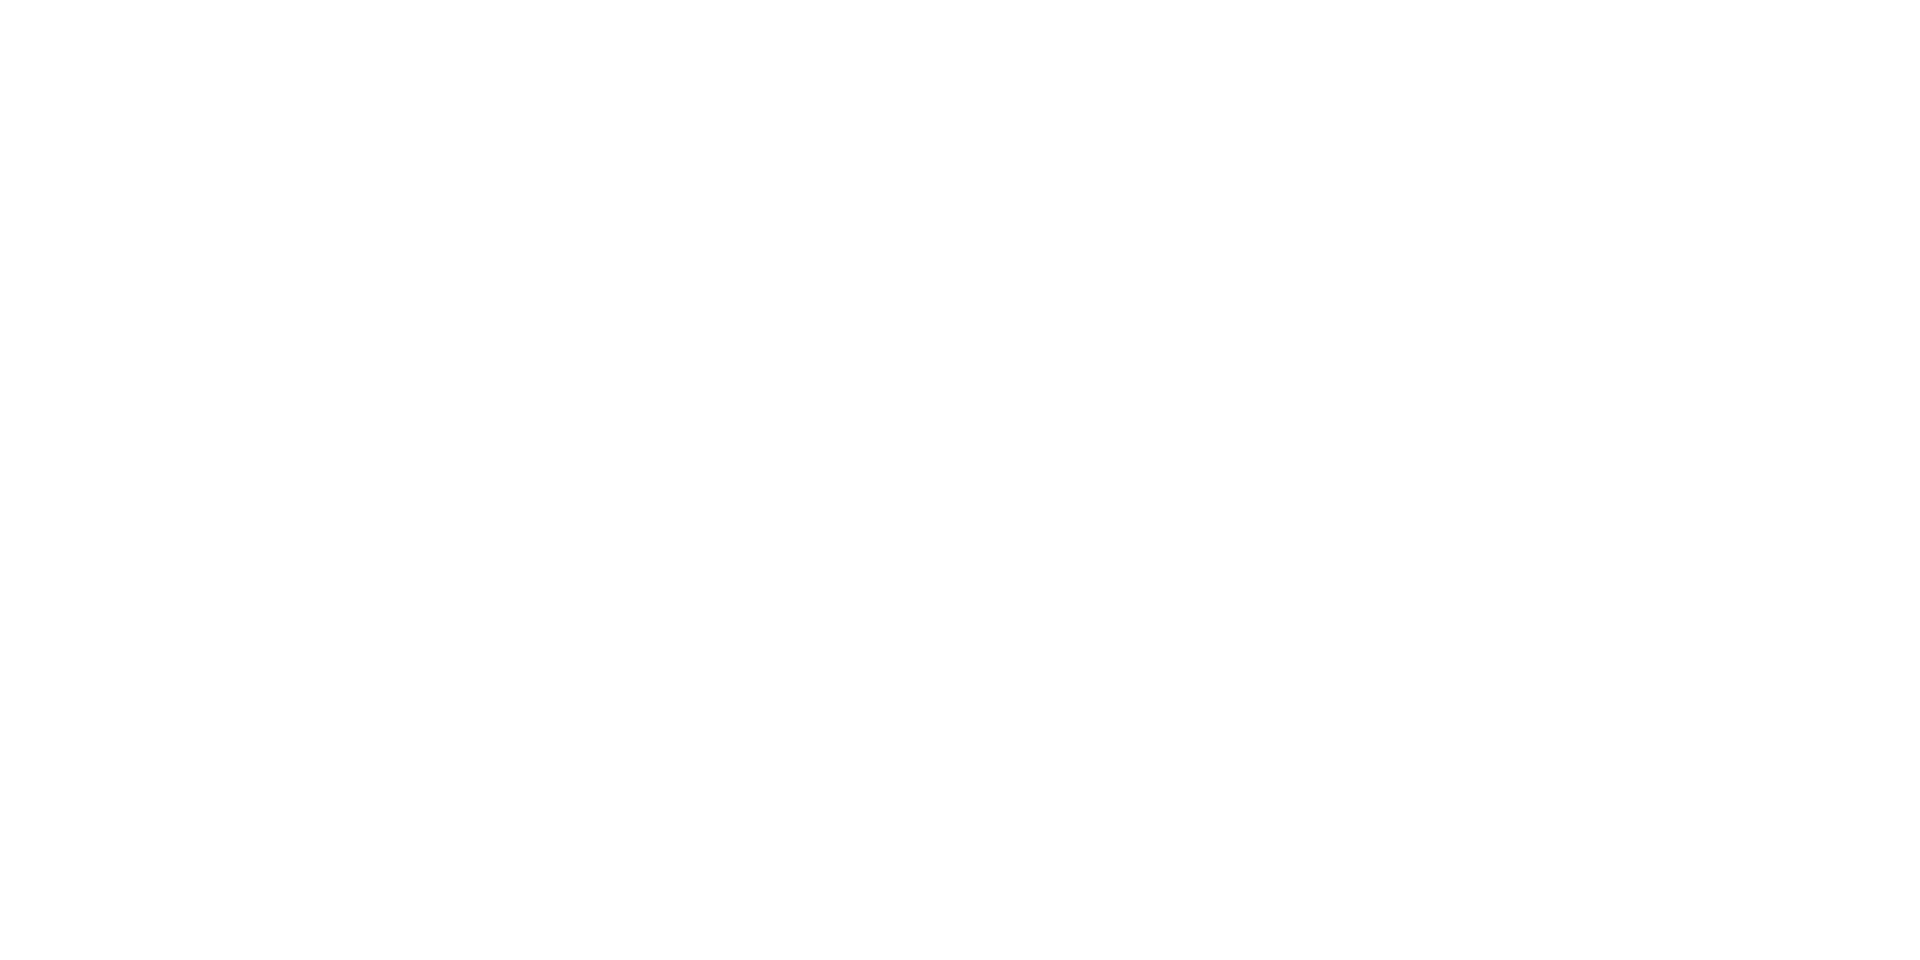

<IPython.core.display.Javascript object>


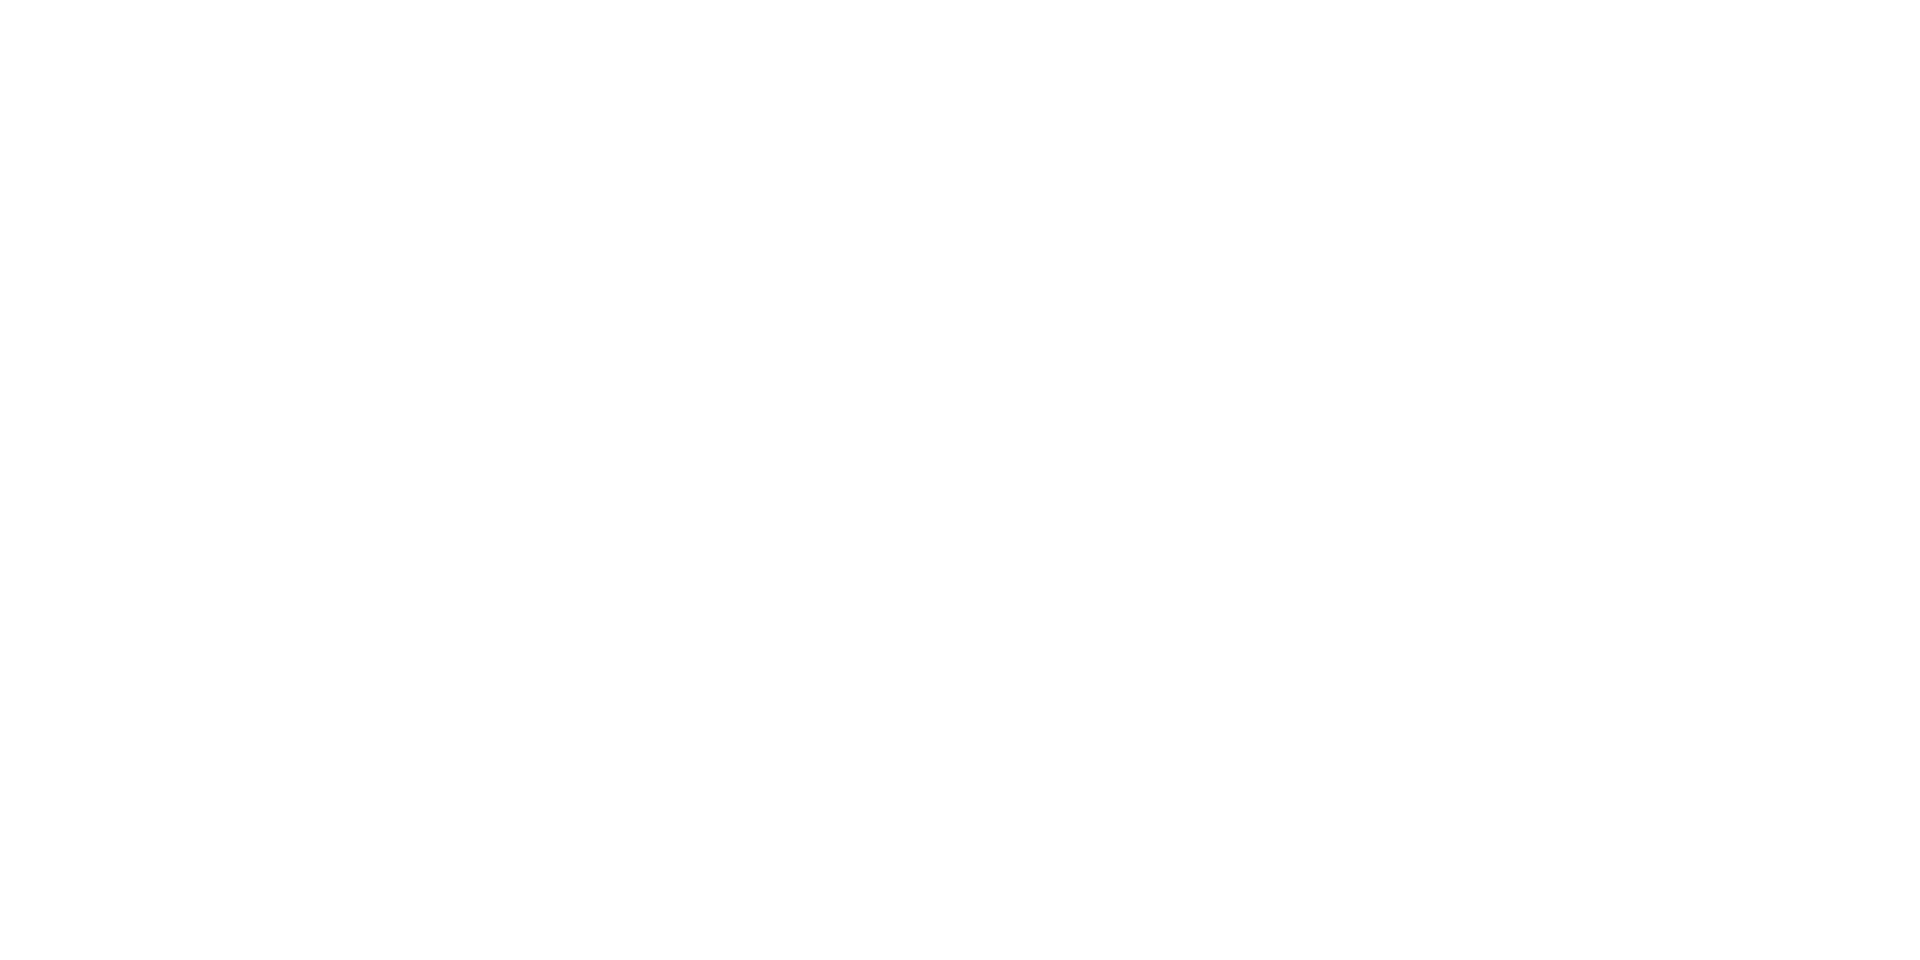

<IPython.core.display.Javascript object>


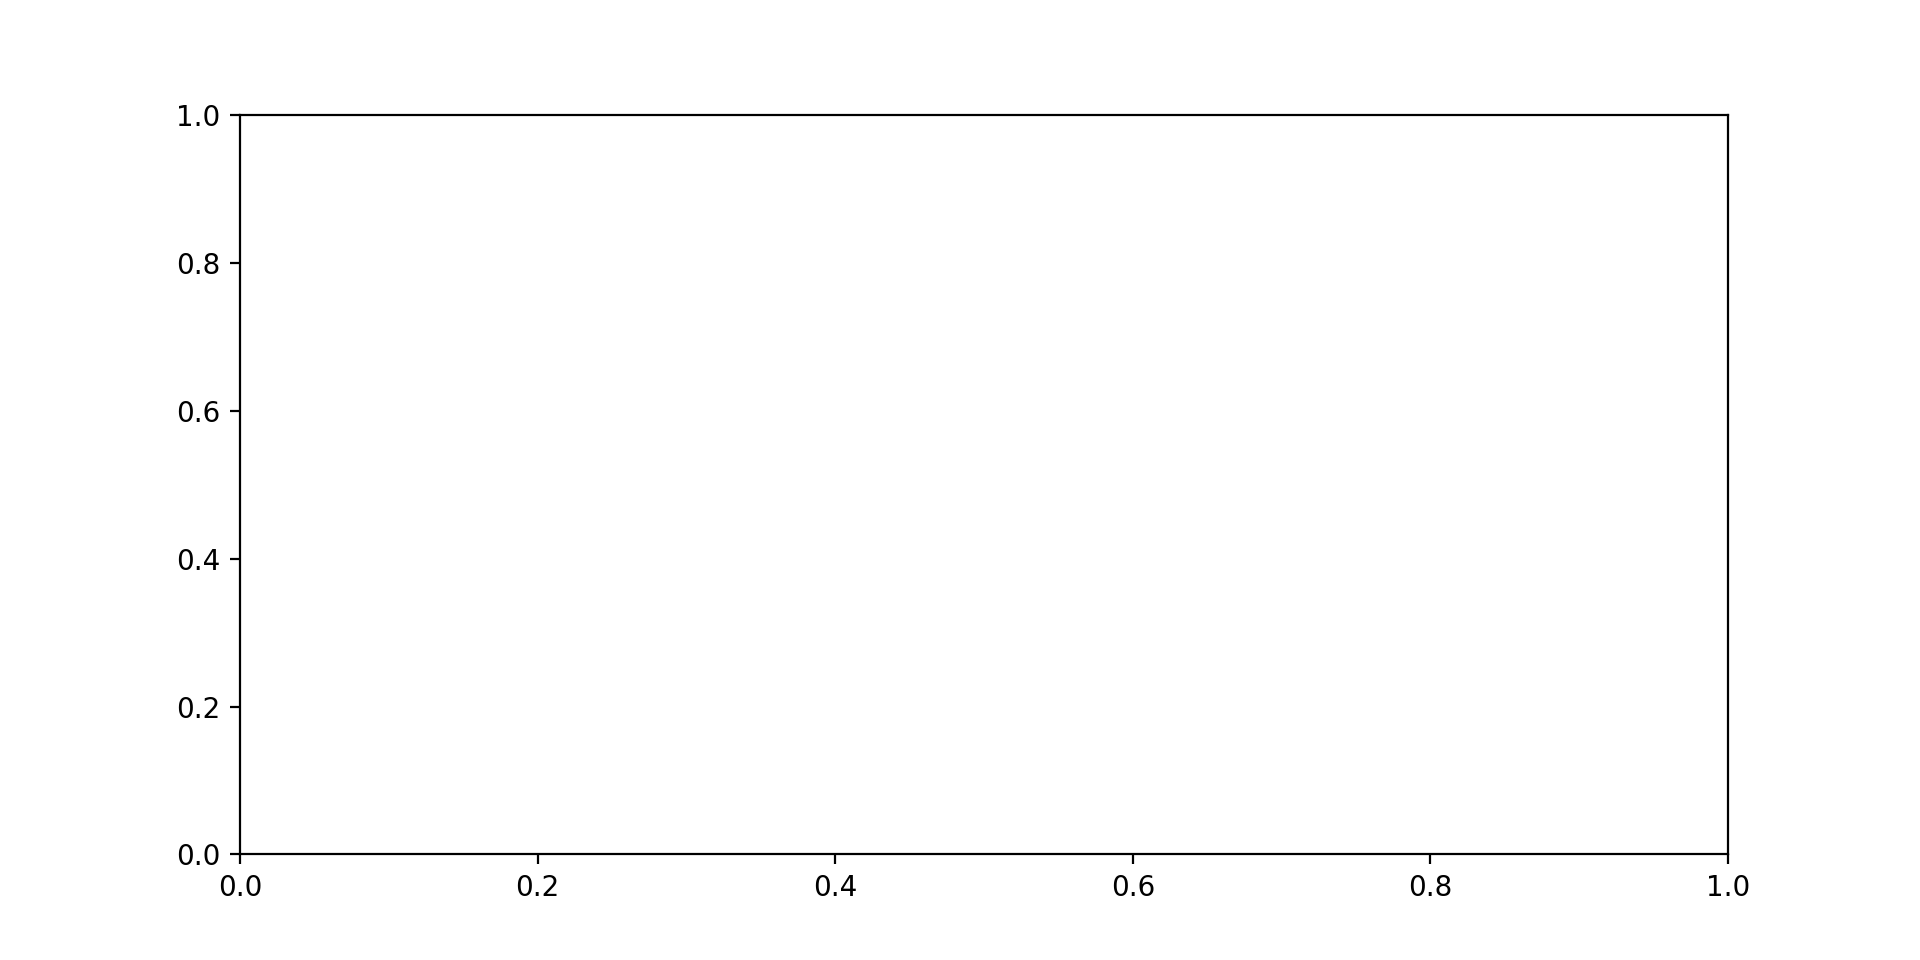

lander env att 2 fixed
PPO Policy 1
Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8
[[-1.]
 [ 0.]
 [ 1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h3/kernel:0', 'means/kernel:0', 'h1/bias:0', 'h2/bias:0', 'h2/kernel:0', 'logvars:0', 'h1/kernel:0', 'h3/bias:0', 'means/bias:0'])


In [3]:
from env_mdr import Env
from reward_terminal_mdr  import Reward
import env_utils as envu
import attitude_utils as attu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
from agent_mdr2 import Agent
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from attitude_constraint import Attitude_constraint
from thruster_model import Thruster_model

logger = Logger()
dynamics_model = Dynamics_model()
attitude_parameterization = attu.Quaternion_attitude()


lander_model = Lander_model(Thruster_model(), attitude_parameterization=attitude_parameterization,
                           apf_v0=70, apf_atarg=15., apf_tau2=100.)
lander_model.get_state_agent = lander_model.get_state_agent_tgo_alt

reward_object = Reward(tracking_bias=0.01,tracking_coeff=-0.01, fuel_coeff=-0.05, debug=False, landing_coeff=10.)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(attitude_parameterization, 
                                          attitude_penalty=-100,attitude_coeff=-10,
                                         attitude_limit=(10*np.pi, np.pi/2-np.pi/16, np.pi/2-np.pi/16))
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          attitude_constraint=attitude_constraint,
          tf_limit=120.0,print_every=10)




obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True)
import utils
fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)
print(input_normalizer)

In [7]:
policy.close_sess()
value_function.close_sess()

NameError: name 'value_function' is not defined

In [7]:
import utils
fname = "small_reward-Copy1"
#utils.save_run(policy,input_normalizer,fname)
utils.save_run(policy,input_normalizer,env.rl_stats.history,fname)

Saved Vars:  ['h1/kernel:0', 'h1/bias:0', 'h2/kernel:0', 'h2/bias:0', 'h3/kernel:0', 'h3/bias:0', 'means/kernel:0', 'means/bias:0', 'logvars:0']


In [6]:
print(input_normalizer)

None


# Test Policy with Realistic Noise


In [4]:
policy.test_mode=True
env.lander.apf_tau1=20
env.lander.apf_tau2=100
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2100,2100,-90,-70),
                           yaw   = (-np.pi/16, np.pi/16, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/16, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/16, np.pi/16, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9956.36 |2658.84 |3200.00 |16000.00 |    57
glideslope | 3.247 | 6.778 | 0.750 |517.872 |     2
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -0.9    -2.1    -0.0 |     2.3     1.4    -0.0
velocity |   0.056  -0.012  -0.950 |   0.022   0.060   0.038 |   0.001  -0.122  -1.032 |   0.101   0.145  -0.847
fuel     |278.04 | 14.62 |253.35 |325.92
attitude_321 |  -0.076  -0.029  -0.014 |   0.127   0.011   0.022 |  -0.364  -0.055  -0.060 |   0.327   0.001   0.048
w        |  -0.030  -0.014   0.000 |   0.049   0.022   0.000 |  -0.147  -0.078  -0.000 |   0.071   0.024   0.000
glideslope |  19.220 |   9.212 |  11.496 |  76.501
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9964.89 |2689.44 |3200.00 |16000.00 |    57
glideslope | 3.268 | 6.616 | 0.750 |517.872 |     2
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |9949.38 |2685.34 |3200.00 |16000.00 |   388
glideslope | 3.361 | 7.910 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -1.2    -2.4    -0.0 |     2.6     3.0    -0.0
velocity |   0.052  -0.018  -0.948 |   0.024   0.061   0.045 |  -0.033  -0.141  -1.090 |   0.125   0.190  -0.787
fuel     |279.92 | 15.55 |251.57 |337.11
attitude_321 |  -0.052  -0.029  -0.015 |   0.137   0.011   0.022 |  -0.390  -0.069  -0.075 |   0.388   0.020   0.061
w        |  -0.032  -0.011   0.000 |   0.051   0.025   0.000 |  -0.171  -0.138  -0.000 |   0.107   0.082   0.000
glideslope |  19.016 |   8.142 |   8.424 | 148.855
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |9949.07 |2686.67 |3200.00 |16000.00 |   388
glideslope | 3.362 | 7.809 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  2300
Cumulative Stats (mean,std,max,argmax)
thrust   |9976.88 |2696.99 |3200.00 |16000.00 |   388
glideslope | 3.474 | 8.043 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.4    -0.1 |     2.6     3.1    -0.0
velocity |   0.052  -0.018  -0.949 |   0.024   0.061   0.045 |  -0.042  -0.142  -1.123 |   0.135   0.190  -0.779
fuel     |279.42 | 15.11 |251.57 |339.12
attitude_321 |  -0.052  -0.028  -0.013 |   0.135   0.011   0.022 |  -0.420  -0.070  -0.075 |   0.390   0.023   0.061
w        |  -0.033  -0.012   0.000 |   0.052   0.025   0.000 |  -0.171  -0.143  -0.000 |   0.118   0.082   0.000
glideslope |  19.246 |   7.720 |   8.424 | 148.855
i :  2400
Cumulative Stats (mean,std,max,argmax)
thrust   |9976.12 |2695.01 |3200.00 |16000.00 |   388
glideslope | 3.481 | 8.056 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  3400
Cumulative Stats (mean,std,max,argmax)
thrust   |9975.31 |2696.75 |3200.00 |16000.00 |   388
glideslope | 3.502 | 7.886 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.4    -0.1 |     2.6     3.5    -0.0
velocity |   0.052  -0.018  -0.949 |   0.024   0.061   0.045 |  -0.042  -0.147  -1.145 |   0.135   0.190  -0.779
fuel     |279.27 | 14.89 |251.57 |339.12
attitude_321 |  -0.052  -0.028  -0.013 |   0.134   0.011   0.022 |  -0.420  -0.070  -0.075 |   0.390   0.023   0.066
w        |  -0.033  -0.011   0.000 |   0.052   0.025   0.000 |  -0.173  -0.144  -0.000 |   0.118   0.082   0.000
glideslope |  19.244 |   7.635 |   8.424 | 148.855
i :  3500
Cumulative Stats (mean,std,max,argmax)
thrust   |9974.28 |2697.14 |3200.00 |16000.00 |   388
glideslope | 3.490 | 7.859 | 0.593 |1793.248 |   775
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  4500
Cumulative Stats (mean,std,max,argmax)
thrust   |9976.09 |2698.18 |3200.00 |16000.00 |   388
glideslope | 3.481 | 8.194 | 0.576 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.5    -0.1 |     2.6     3.5    -0.0
velocity |   0.052  -0.017  -0.949 |   0.024   0.061   0.045 |  -0.042  -0.153  -1.145 |   0.135   0.192  -0.778
fuel     |279.45 | 14.95 |251.57 |339.69
attitude_321 |  -0.053  -0.028  -0.013 |   0.134   0.011   0.022 |  -0.420  -0.070  -0.075 |   0.537   0.023   0.066
w        |  -0.032  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.175  -0.144  -0.000 |   0.123   0.082   0.000
glideslope |  19.145 |   7.386 |   8.424 | 148.855
i :  4600
Cumulative Stats (mean,std,max,argmax)
thrust   |9975.47 |2697.37 |3200.00 |16000.00 |   388
glideslope | 3.486 | 8.163 | 0.576 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  5600
Cumulative Stats (mean,std,max,argmax)
thrust   |9968.13 |2694.34 |3200.00 |16000.00 |   388
glideslope | 3.474 | 8.022 | 0.559 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.5    -0.1 |     2.6     3.5    -0.0
velocity |   0.052  -0.017  -0.949 |   0.024   0.061   0.045 |  -0.045  -0.153  -1.145 |   0.135   0.213  -0.778
fuel     |279.49 | 14.95 |251.43 |343.00
attitude_321 |  -0.054  -0.028  -0.013 |   0.135   0.011   0.022 |  -0.423  -0.070  -0.076 |   0.537   0.023   0.066
w        |  -0.032  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.181  -0.144  -0.000 |   0.123   0.086   0.000
glideslope |  19.156 |   7.892 |   8.424 | 188.851
i :  5700
Cumulative Stats (mean,std,max,argmax)
thrust   |9965.85 |2694.20 |3200.00 |16000.00 |   388
glideslope | 3.474 | 8.004 | 0.557 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |9965.21 |2690.78 |3200.00 |16000.00 |   388
glideslope | 3.492 | 7.974 | 0.266 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.5    -0.1 |     2.6     3.5    -0.0
velocity |   0.052  -0.017  -0.949 |   0.024   0.061   0.045 |  -0.045  -0.183  -1.145 |   0.135   0.213  -0.756
fuel     |279.48 | 15.07 |251.43 |360.62
attitude_321 |  -0.055  -0.028  -0.014 |   0.134   0.011   0.022 |  -0.429  -0.070  -0.076 |   0.537   0.023   0.066
w        |  -0.032  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.198  -0.144  -0.000 |   0.123   0.086   0.000
glideslope |  19.144 |   8.237 |   8.424 | 260.004
i :  6800
Cumulative Stats (mean,std,max,argmax)
thrust   |9964.12 |2690.09 |3200.00 |16000.00 |   388
glideslope | 3.492 | 7.967 | 0.266 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  7800
Cumulative Stats (mean,std,max,argmax)
thrust   |9961.78 |2689.06 |3200.00 |16000.00 |   388
glideslope | 3.495 | 8.042 | 0.266 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.5    -0.1 |     2.7     5.3    -0.0
velocity |   0.052  -0.016  -0.948 |   0.024   0.062   0.045 |  -0.045  -0.183  -1.145 |   0.135   0.213  -0.753
fuel     |279.45 | 15.05 |251.11 |360.62
attitude_321 |  -0.055  -0.028  -0.013 |   0.135   0.011   0.022 |  -0.429  -0.070  -0.076 |   0.537   0.025   0.066
w        |  -0.031  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.198  -0.146  -0.000 |   0.123   0.086   0.000
glideslope |  19.139 |   8.248 |   8.424 | 260.004
i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |9961.49 |2688.38 |3200.00 |16000.00 |   388
glideslope | 3.497 | 8.027 | 0.266 |2174.922 |  4081
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F

i :  8900
Cumulative Stats (mean,std,max,argmax)
thrust   |9962.78 |2688.66 |3200.00 |16000.00 |   388
glideslope | 3.536 | 9.944 | 0.266 |3395.133 |  8007
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -1.6    -2.5    -0.1 |     2.7     5.3    -0.0
velocity |   0.052  -0.016  -0.949 |   0.024   0.061   0.045 |  -0.045  -0.183  -1.145 |   0.135   0.213  -0.753
fuel     |279.39 | 15.01 |249.01 |360.62
attitude_321 |  -0.056  -0.028  -0.013 |   0.134   0.011   0.022 |  -0.429  -0.070  -0.076 |   0.537   0.025   0.066
w        |  -0.031  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.198  -0.146  -0.000 |   0.123   0.086   0.000
glideslope |  19.150 |   8.136 |   8.424 | 260.004
i :  9000
Cumulative Stats (mean,std,max,argmax)
thrust   |9962.77 |2688.75 |3200.00 |16000.00 |   388
glideslope | 3.539 | 9.929 | 0.266 |3395.133 |  8007
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

F


Cumulative Stats (mean,std,max,argmax)
thrust   |9962.08 |2688.61 |3200.00 |16000.00 |   388
glideslope | 3.527 | 9.791 | 0.266 |3395.133 |  8007
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.5     0.1    -0.0 |     0.5     0.4     0.0 |    -2.1    -2.5    -0.1 |     2.7     5.3    -0.0
velocity |   0.052  -0.016  -0.949 |   0.024   0.061   0.045 |  -0.045  -0.183  -1.145 |   0.135   0.213  -0.747
fuel     |279.42 | 15.05 |249.01 |360.62
attitude_321 |  -0.056  -0.028  -0.014 |   0.134   0.011   0.022 |  -0.429  -0.073  -0.076 |   0.537   0.032   0.066
w        |  -0.031  -0.011  -0.000 |   0.052   0.025   0.000 |  -0.198  -0.146  -0.000 |   0.123   0.086   0.000
glideslope |  19.138 |   8.135 |   8.424 | 260.004

Initial Stats (mean,std,min,max)
position |   993.7    -9.5  2100.0 |   578.2   576.5     0.0 |     0.3  -999.9  2100.0 |  2000.0   999.9  2100.0
velocity | -39.946  -0.062 -80.025 |  17.318  17.238   5.806 | -69.994 -2

In [ ]:
policy.test_mode=True
env.lander.apf_tau1=20
env.lander.apf_tau2=100
env.ic_gen = Landing_icgen(mass_uncertainty=0.03, g_uncertainty=(0.0,0.0),
                           adapt_apf_v0=True,
                           attitude_parameterization=attitude_parameterization,
                           downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2000,2100,-90,-70),
                           yaw   = (-np.pi/8, np.pi/8, 0.0, 0.0) ,
                           pitch = (np.pi/4-np.pi/8, np.pi/4+np.pi/16, -0.0, 0.0),
                           roll  = (-np.pi/8, np.pi/8, -0.0, 0.0),
                          noise_u=100*np.ones(3), noise_sd=100*np.ones(3))
env.test_policy_batch(policy,input_normalizer,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10001.54 |2677.40 |3200.00 |16000.00 |    11
glideslope | 3.517 | 7.060 | 0.760 |229.665 |    59
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.0    -0.0 |     0.5     0.4     0.0 |    -1.0    -1.5    -0.0 |     1.8     1.4    -0.0
velocity |   0.052  -0.024  -0.945 |   0.027   0.067   0.046 |  -0.006  -0.131  -1.057 |   0.121   0.150  -0.845
fuel     |276.71 | 14.32 |251.07 |315.91
attitude_321 |  -0.035  -0.027  -0.012 |   0.152   0.013   0.023 |  -0.360  -0.058  -0.059 |   0.237  -0.002   0.063
w        |  -0.040  -0.012  -0.000 |   0.057   0.027   0.000 |  -0.173  -0.126  -0.000 |   0.093   0.051   0.000
glideslope |  19.453 |   6.955 |   8.644 |  43.984
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9984.85 |2708.95 |3200.00 |16000.00 |    11
glideslope | 3.427 | 8.338 | 0.669 |1196.315 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Fin

i :  1200
Cumulative Stats (mean,std,max,argmax)
thrust   |10000.80 |2726.21 |3200.00 |16000.00 |   891
glideslope | 3.349 | 7.556 | 0.643 |1209.796 |   684
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
position |     0.4     0.1    -0.0 |     0.5     0.4     0.0 |    -1.7    -2.3    -0.1 |     2.6     2.7    -0.0
velocity |   0.054  -0.018  -0.950 |   0.024   0.062   0.045 |  -0.017  -0.148  -1.121 |   0.121   0.212  -0.779
fuel     |278.02 | 15.40 |249.72 |331.58
attitude_321 |  -0.049  -0.029  -0.014 |   0.147   0.012   0.022 |  -0.413  -0.066  -0.067 |   0.413   0.021   0.063
w        |  -0.032  -0.012  -0.000 |   0.053   0.026   0.000 |  -0.179  -0.151  -0.000 |   0.118   0.061   0.000
glideslope |  19.140 |   7.398 |   8.644 |  73.946
i :  1300
Cumulative Stats (mean,std,max,argmax)
thrust   |10004.20 |2726.12 |3200.00 |16000.00 |   891
glideslope | 3.338 | 7.434 | 0.643 |1209.796 |   684
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0
